# Simple Real-Time Pipeline

### Setup MLRun Project

In [1]:
import mlrun
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
project = mlrun.get_or_create_project("real-time-pipeline", "./")

> 2023-04-03 19:52:14,166 [info] Created and saved project real-time-pipeline: {'from_template': None, 'overwrite': False, 'context': './', 'save': True}
> 2023-04-03 19:52:14,167 [info] created project real-time-pipeline and saved in MLRun DB


### Define Model Class, Router, and Transformations

In [13]:
%%writefile serve.py

def mult_by_two(event):
    event["number"] *= 2
    return event

class MultByX:
    def __init__(self, x):
        self.x = x
        
    def do(self, event):
        event["number"] *= self.x
        return event

Overwriting serve.py


### Define Graph

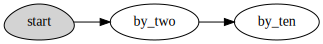

In [15]:
fn = project.set_function(
    name="real-time-pipeline", func="serve.py", 
    kind="serving", image="mlrun/mlrun"
)
graph = fn.set_topology("flow", engine="async")

graph.add_step(name="by_two", handler="mult_by_two")
graph.add_step(name="by_ten", class_name="MultByX", x=10, after="$prev").respond()

graph.plot(rankdir="LR")

### Test Locally

In [16]:
from serve import *

In [17]:
mock_server = fn.to_mock_server()

In [18]:
body = {
    "number" : 5
}

In [19]:
mock_server.test("", body={"number" : 5})

{'number': 100}

### Deploy on K8s

In [20]:
fn.deploy()

> 2023-04-03 19:56:34,308 [info] Starting remote function deploy
2023-04-03 19:56:34  (info) Deploying function
2023-04-03 19:56:34  (info) Building
2023-04-03 19:56:34  (info) Staging files and preparing base images
2023-04-03 19:56:34  (info) Building processor image
2023-04-03 19:57:30  (info) Build complete
2023-04-03 19:57:38  (info) Function deploy complete
> 2023-04-03 19:57:38,897 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-real-time-pipeline-real-time-pipeline.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['real-time-pipeline-real-time-pipeline-real-time-pipeline.default-tenant.app.us-sales-350.iguazio-cd1.com/']}


'http://real-time-pipeline-real-time-pipeline-real-time-pipeline.default-tenant.app.us-sales-350.iguazio-cd1.com/'

In [25]:
fn.invoke("", body={"number" : 5})

> 2023-04-03 19:58:57,743 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-real-time-pipeline-real-time-pipeline.default-tenant.svc.cluster.local:8080/'}


{'number': 100}